# Masterarbeit (Batch-Tool)

In [1]:
# Tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

#Use notebook for interactive plots
#%matplotlib notebook
%matplotlib inline

In [2]:
# JSON Lib
! pip install demjson
import demjson

In [3]:
# Natural Language Toolkit
! pip install nltk
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# WordCloud
! pip install wordcloud
from wordcloud import WordCloud

In [5]:
# Show all columns
pd.set_option('display.max_columns', None)

In [6]:
# Dateien ausgeben und Variablen setzen
dir_var = "../"
! ls -al ../

total 32
drwxr-xr-x 10 jovyan users   320 Dec 11 14:25 .
drwsrwsr-x  1 jovyan users  4096 Dec 13 13:47 ..
drwxr-xr-x 33 jovyan users  1056 Dec 11 14:25 DS-08-10-2020
drwxr-xr-x 18 jovyan users   576 Dec 11 14:25 DS-22-10-2020
drwxr-xr-x 14 jovyan users   448 Dec 13 13:49 .git
-rw-r--r--  1 jovyan users    43 Dec 11 14:25 .gitattributes
-rw-r--r--  1 jovyan users    30 Dec 11 14:25 .gitignore
-rw-r--r--  1 jovyan users 11357 Dec 11 14:25 LICENSE
drwxr-xr-x  5 jovyan users   160 Dec 13 14:39 notebooks
-rw-r--r--  1 jovyan users   172 Dec 13 13:03 README.md


## Process jobs

In [7]:
dfInputFiles = pd.read_excel(dir_var + "notebooks/inputFiles.xlsx", header=None, names=["inputName", "inputPath", "inputType", "inputId"])

### !!!!!!!!!!!!!!!! Quick Filter !!!!!!!!!!!!!!!!!!!!

In [8]:
# Take only samples
#dfInputFiles = dfInputFiles.tail(45)
#dfInputFiles = dfInputFiles.head(1)
#dfInputFiles = dfInputFiles[dfInputFiles.inputName.str.contains("FREIHEIT")]

### Overview jobs

In [9]:
dfInputFiles

,inputName,inputPath,inputType,inputId
2,ATTILA HILDMANN OFFICIAL ⚫️⚪️🔴⚔️,DS-08-10-2020/ChatExport_2020-09-25-hildmann,public_channel,10034163583


### Transform jobs

In [10]:
def convertToDataFrameMeta(filePath):
    dF = pd.read_json(dir_var + filePath + "/result.json", encoding='utf-8')
    return dF

In [11]:
def convertToDataFrameMessages(filePath, dictMeta):
    dF = pd.json_normalize(dictMeta[filePath].messages)
    return dF

In [12]:
def checkIsFormattedText(text):
    textString = str(text)
    if(textString.startswith("[") == True and textString.endswith("]") == True):
        return True
    else:
        return False

In [13]:
# See below
def getExtractedParam(param, processedTextData):
    a,b,c,d,e,f,g = processedTextData
    switcher = {
        0: a,
        1: b,
        2: c,
        3: d,
        4: e,
        5: f,
        6: g
    }
    return switcher.get(param)

In [14]:
# TODO: What href in normal text?

# Return types (see above)

# a = processedText
# b = Items 'processedURLs'
# c = Items 'processedHashtags'
# d = Items 'processedBolds'
# e = Items 'processedItalics'
# f = Items 'processedUnderlines'
# g = Items 'processedEmails'

def extractTextData(processedIsFormattedText, text):
    
    # 3 returns!
    
    processedURLs       = list()
    processedHashtags   = list()
    processedBolds      = list()
    processedItalics    = list()
    processedUnderlines = list()
    processedEmails     = list()
    
    if(processedIsFormattedText != True):
        #Is no JSON
        return (text, processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)
    else:
        #Is json try to parse
        try:
            jsonList = demjson.decode(str(text), encoding='utf8')

            returnList = []

            # Do for each item in list
            for lItem in jsonList:

                messageString = str(lItem)

                isFormatted = messageString.startswith("{") and messageString.endswith("}")

                if(isFormatted):
                    # Is Json Sub String
                    subJsonString = demjson.decode(str(messageString), encoding='utf8')
                    subJsonType = subJsonString["type"]

                    if(subJsonType == "bold"):
                        #text included
                        processedBolds.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "italic"):
                        #text included
                        processedItalics.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "underline"):
                        #text included
                        processedUnderlines.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                    
                    elif(subJsonType == "email"):
                        #text included
                        processedEmails.append(subJsonString["text"])
                        
                    elif(subJsonType == "text_link"):
                        #text and href included
                        processedURLs.append(subJsonString["href"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "link"):
                        #text included
                        processedURLs.append(subJsonString["text"])
                        
                    elif(subJsonType == "hashtag"):
                        #text included
                        processedHashtags.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention_name"):
                        #text and user_id included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bot_command"):
                        #text included
                        returnList = returnList 
                        
                    elif(subJsonType == "code"):
                        #text included
                        returnList = returnList
                        
                    elif(subJsonType == "phone"):
                        #text included
                        returnList = returnList
                        
                    elif(subJsonType == "strikethrough"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "pre"):
                        #text and language included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bank_card"):
                        #text included
                        returnList = returnList
                        
                    else:
                        print("- Error: Unknown type " + subJsonType)
                        returnList = returnList

                else:
                    # Is Normal Sub String
                    returnList.append(messageString)

            return (''.join(returnList), processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)
        
        except:
            #Parser error
            print("- Warn: Json parser error (set return text to inputText) >>" + text + "<<")
            return (text, processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)

In [15]:
# Timer Start
timeStartGlobal = time.time()

# Add Key = filePath / Value = DataFrame (Metadata)
dictMeta = {}
for fP in dfInputFiles.inputPath:
    
    dictMeta[fP] = convertToDataFrameMeta(fP)

# Add Key = filePath / Value = DataFrame (Messages)
dictMessages = {}
for fP in dfInputFiles.inputPath:

    timeStartSingle = time.time()
    print("[Process now " + fP + "]")
    dfMessages = convertToDataFrameMessages(fP, dictMeta)
    
    dfMessages["processedChannelFilePath"]  = fP
    dfMessages["processedChannelType"]      = dictMeta[fP].type.iloc[0]
    dfMessages["processedRawTextSize"]      = dfMessages["text"].str.len()
    dfMessages["processedIsFormattedText"]  = dfMessages["text"].apply(checkIsFormattedText)
    
    dfMessages["extractedTextData"]      = dfMessages.apply(lambda x: extractTextData(x.processedIsFormattedText, x.text), axis=1)
    dfMessages["processedValidText"]     = dfMessages.apply(lambda x: getExtractedParam(0, x.extractedTextData), axis=1)
    dfMessages["processedValidTextSize"] = dfMessages["processedValidText"].str.len()
    
    dfMessages["processedTextDataURLs"]       = dfMessages.apply(lambda x: getExtractedParam(1, x.extractedTextData), axis=1)
    dfMessages["processedTextDataHashtags"]   = dfMessages.apply(lambda x: getExtractedParam(2, x.extractedTextData), axis=1)
    dfMessages["processedTextDataBolds"]      = dfMessages.apply(lambda x: getExtractedParam(3, x.extractedTextData), axis=1)
    dfMessages["processedTextDataItalics"]    = dfMessages.apply(lambda x: getExtractedParam(4, x.extractedTextData), axis=1)
    dfMessages["processedTextDataUnderlines"] = dfMessages.apply(lambda x: getExtractedParam(5, x.extractedTextData), axis=1)
    dfMessages["processedTextDataEmails"]     = dfMessages.apply(lambda x: getExtractedParam(6, x.extractedTextData), axis=1)
    
    dictMessages[fP] = dfMessages
    timeEndSingle = time.time()
    print('{:5.3f}s'.format(timeEndSingle-timeStartSingle))

# All Messages to DataFrame
dfAllDataMessages = pd.DataFrame()
for fP in dfInputFiles.inputPath:
    
    print("[Append now " + fP + "]")
    dfMessages        = dictMessages[fP].copy()
    dfAllDataMessages = dfAllDataMessages.append(dfMessages)

# Print Time
timeEndGlobal = time.time()
print()
print("[Finished global]")
print('{:5.3f}s'.format(timeEndGlobal-timeStartGlobal))

[Process now DS-08-10-2020/ChatExport_2020-09-25-hildmann]
29.730s
[Append now DS-08-10-2020/ChatExport_2020-09-25-hildmann]

[Finished global]
29.957s


### Debug

In [16]:
#dfMessages = dfAllDataMessages.copy()
#dfMessages = dfMessages[dfMessages.astype(str)["processedTextDataEmails"] != "[]"]
#t = dfMessages.sort_values(by="processedValidTextSize", ascending=False).iloc[3]
#print(">>" + str(t.text) + "<<")
#print()
#print(">>" + str(t.processedTextDataBolds) + "<<")
#print(">>" + str(t.processedTextDataURLs) + "<<")
#print(">>" + str(t.processedTextDataHashtags) + "<<")
#print(">>" + str(t.processedTextDataItalics) + "<<")
#print(">>" + str(t.processedTextDataUnderlines) + "<<")
#print(">>" + str(t.processedTextDataEmails) + "<<")

### Type of channels

In [17]:
dfInputFiles.inputType.value_counts()

public_channel    1
Name: inputType, dtype: int64

### Only in different types of channels

In [18]:
dfAllDataMessages.columns.difference(
    dfAllDataMessages[dfAllDataMessages.processedChannelType == "public_channel"].dropna(how='all', axis=1).columns
)

Index([], dtype='object')

In [19]:
dfAllDataMessages.columns.difference(
    dfAllDataMessages[dfAllDataMessages.processedChannelType == "public_supergroup"].dropna(how='all', axis=1).columns
)

Index(['action', 'date', 'duration_seconds', 'edited', 'extractedTextData',
       'file', 'forwarded_from', 'height', 'id',
       'live_location_period_seconds', 'location_information.latitude',
       'location_information.longitude', 'media_type', 'message_id',
       'mime_type', 'performer', 'photo', 'poll.answers', 'poll.closed',
       'poll.question', 'poll.total_voters', 'processedChannelFilePath',
       'processedChannelType', 'processedIsFormattedText',
       'processedRawTextSize', 'processedTextDataBolds',
       'processedTextDataEmails', 'processedTextDataHashtags',
       'processedTextDataItalics', 'processedTextDataURLs',
       'processedTextDataUnderlines', 'processedValidText',
       'processedValidTextSize', 'reply_to_message_id', 'sticker_emoji',
       'text', 'thumbnail', 'title', 'type', 'via_bot', 'width'],
      dtype='object')

In [20]:
# Vorsicht: Wenige Daten
dfAllDataMessages.columns.difference(
    dfAllDataMessages[dfAllDataMessages.processedChannelType == "private_supergroup"].dropna(how='all', axis=1).columns
)

Index(['action', 'date', 'duration_seconds', 'edited', 'extractedTextData',
       'file', 'forwarded_from', 'height', 'id',
       'live_location_period_seconds', 'location_information.latitude',
       'location_information.longitude', 'media_type', 'message_id',
       'mime_type', 'performer', 'photo', 'poll.answers', 'poll.closed',
       'poll.question', 'poll.total_voters', 'processedChannelFilePath',
       'processedChannelType', 'processedIsFormattedText',
       'processedRawTextSize', 'processedTextDataBolds',
       'processedTextDataEmails', 'processedTextDataHashtags',
       'processedTextDataItalics', 'processedTextDataURLs',
       'processedTextDataUnderlines', 'processedValidText',
       'processedValidTextSize', 'reply_to_message_id', 'sticker_emoji',
       'text', 'thumbnail', 'title', 'type', 'via_bot', 'width'],
      dtype='object')

## Queries

In [21]:
def queryChannelId(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["id"].iloc[0])

In [22]:
def queryChannelName(filePath):
    dfMeta = dictMeta[filePath].copy()
    inputStr  = str(dfMeta["name"].iloc[0])
    outputStr = inputStr.encode('ascii', 'ignore')
    outputStr = outputStr.decode('ascii')
    return outputStr[:25]

In [23]:
def queryChannelType(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["type"].iloc[0])

In [24]:
def queryChannelCountEntries(filePath):
    dfMessages = dictMessages[filePath].copy()
    return len(dfMessages.index)

In [25]:
def queryChannelCountRawText(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.processedRawTextSize > 0]
    return len(dfMessages.index)

In [26]:
def queryChannelCountIsFormattedText(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.processedIsFormattedText == True]
    return len(dfMessages.index)

In [27]:
def queryChannelCountValidText(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.processedValidTextSize > 0]
    return len(dfMessages.index)

In [28]:
# TODO mit process
def queryChannelCountPhoto(filePath):
    dfMessages = dictMessages[filePath].copy()
    if "photo" not in dfMessages.columns:
        return 0
    else:
        dfMessages = dfMessages.photo.dropna()
        return len(dfMessages.index)

In [29]:
# TODO mit process
def queryChannelCountFile(filePath):
    dfMessages = dictMessages[filePath].copy()
    if "file" not in dfMessages.columns:
        return 0
    else:
        dfMessages = dfMessages.file.dropna()
        return len(dfMessages.index)

In [30]:
# TODO mit process
def queryChannelCountEdited(filePath):
    dfMessages = dictMessages[filePath].copy()
    if "edited" not in dfMessages.columns:
        return 0
    else:
        dfMessages = dfMessages.edited.dropna()
        return len(dfMessages.index)

In [31]:
def queryCalcPercent(countFiltered, countTotal):
    return (countFiltered / countTotal) * 100

In [32]:
# Refactor

dfQueryMeta = pd.DataFrame(dfInputFiles.inputPath)

dfQueryMeta["queryChannelId"]                     = dfQueryMeta.inputPath.apply(queryChannelId)
dfQueryMeta["queryChannelName"]                   = dfQueryMeta.inputPath.apply(queryChannelName)
dfQueryMeta["queryChannelType"]                   = dfQueryMeta.inputPath.apply(queryChannelType)
dfQueryMeta["queryChannelCountEntries"]           = dfQueryMeta.inputPath.apply(queryChannelCountEntries)

dfQueryMeta["queryChannelCountRawText"]           = dfQueryMeta.inputPath.apply(queryChannelCountRawText)
dfQueryMeta["queryChannelCountIsFormattedText"]   = dfQueryMeta.inputPath.apply(queryChannelCountIsFormattedText)
dfQueryMeta["queryChannelCountValidText"]         = dfQueryMeta.inputPath.apply(queryChannelCountValidText)
dfQueryMeta["queryChannelCountPhoto"]             = dfQueryMeta.inputPath.apply(queryChannelCountPhoto)
dfQueryMeta["queryChannelCountFile"]              = dfQueryMeta.inputPath.apply(queryChannelCountFile)
dfQueryMeta["queryChannelCountEdited"]            = dfQueryMeta.inputPath.apply(queryChannelCountEdited)

dfQueryMeta["queryChannelPercentRawText"]         = queryCalcPercent(dfQueryMeta["queryChannelCountRawText"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentIsFormattedText"] = queryCalcPercent(dfQueryMeta["queryChannelCountIsFormattedText"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentValidText"]       = queryCalcPercent(dfQueryMeta["queryChannelCountValidText"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentPhoto"]           = queryCalcPercent(dfQueryMeta["queryChannelCountPhoto"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentFile"]            = queryCalcPercent(dfQueryMeta["queryChannelCountFile"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentEdited"]          = queryCalcPercent(dfQueryMeta["queryChannelCountEdited"], dfQueryMeta["queryChannelCountEntries"])

dfQueryMeta.sort_values(by="queryChannelCountEntries", ascending=False)

,inputPath,queryChannelId,queryChannelName,queryChannelType,queryChannelCountEntries,queryChannelCountRawText,queryChannelCountIsFormattedText,queryChannelCountValidText,queryChannelCountPhoto,queryChannelCountFile,queryChannelCountEdited,queryChannelPercentRawText,queryChannelPercentIsFormattedText,queryChannelPercentValidText,queryChannelPercentPhoto,queryChannelPercentFile,queryChannelPercentEdited
2,DS-08-10-2020/ChatExport_2020-09-25-hildmann,10034163583,ATTILA HILDMANN OFFICIAL,public_channel,22204,16285,10026,13965,7840,1935,3183,73.342641,45.154026,62.894073,35.308953,8.714646,14.335255


### Plotter

In [33]:
def queryPlotter(attributeName):
    dfFilter = dfQueryMeta.copy()
    sns.catplot(
        y="queryChannelName",
        x=attributeName,
        data=dfFilter,
        hue="queryChannelType",
        #aspect=1.2,
        #palette="rocket",
        kind="bar",
        height=7,
        order=dfFilter.sort_values(attributeName, ascending=False).queryChannelName
    )

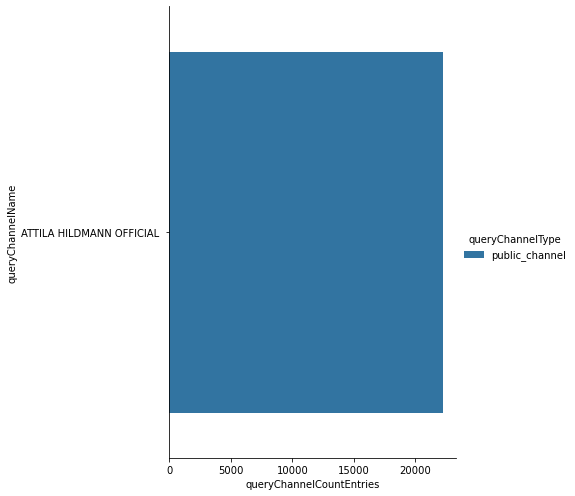

In [34]:
queryPlotter("queryChannelCountEntries")

In [35]:
#queryPlotter("queryChannelPercentRawText")

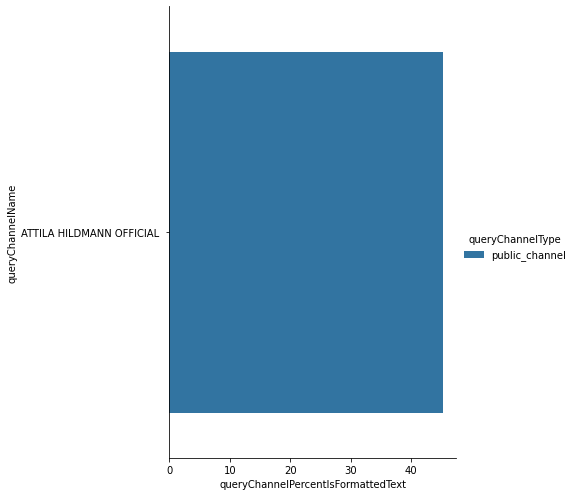

In [36]:
queryPlotter("queryChannelPercentIsFormattedText")

In [37]:
#queryPlotter("queryChannelPercentValidText") 

In [38]:
#queryPlotter("queryChannelPercentPhoto")

In [39]:
#queryPlotter("queryChannelPercentFile")

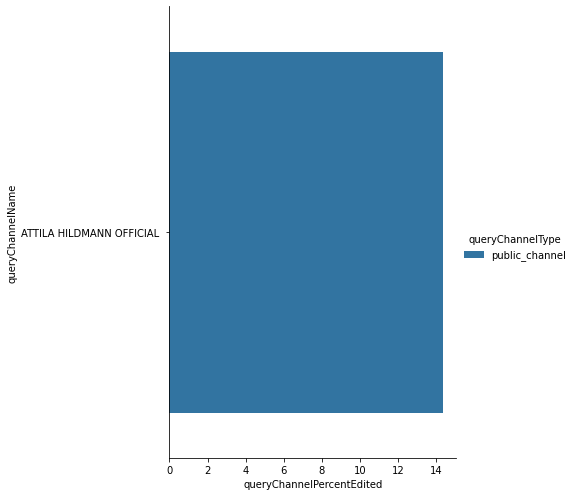

In [40]:
queryPlotter("queryChannelPercentEdited")

## Get valid text

In [41]:
def normalizedValidTextSize(df):
    df = df.copy()
    # https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    # keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
    return df[np.abs(df.processedValidTextSize-df.processedValidTextSize.mean()) <= (3*df.processedValidTextSize.std())]

Before all filters		22204
Before normalizedValidTextSize	12935
After normalizedValidTextSize	12727


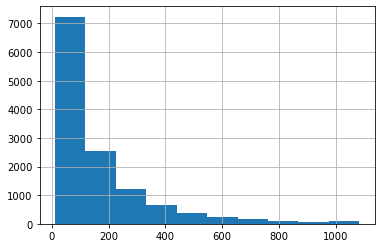

In [42]:
dfMessages = dfAllDataMessages.copy()
print("Before all filters\t\t" + str(len(dfMessages.index)))

dfMessages = dfMessages[dfMessages.processedValidTextSize > 10]
print("Before normalizedValidTextSize\t" + str(len(dfMessages.index)))

dfMessages = normalizedValidTextSize(dfMessages)
print("After normalizedValidTextSize\t" + str(len(dfMessages.index)))

_ = dfMessages.processedValidTextSize.hist()

## Word Clouds

In [43]:
#TODO Difference capital letters?
#TODO Context?

# Use "global" for all DataFrames
def plotChannelWordCloud(filePath, label, filterList):
    timeStart = time.time()
    
    if(filePath != "global"):
        dfMessages = dictMessages[filePath].copy()
    else:
        dfMessages = dfAllDataMessages.copy()
    
    print("[Start transform text to global text string]")
    textList = []
    for index, row in dfMessages.iterrows():
        textList.append(" " + row["processedValidText"])
        
    textString = ''.join(textList)
    
    germanStopWordsList = nltk.corpus.stopwords.words('german')
    germanStopWordsList.append("http")
    germanStopWordsList.append("https")
    germanStopWordsList.append("ja") #TODO: split to local - maybe?
    germanStopWordsList.append("mehr")
    germanStopWordsList.append("mal")
    germanStopWordsList.append("schon")
    germanStopWordsList.append("immer")
    germanStopWordsList.append("wurde")
    germanStopWordsList.append("wurden")
    germanStopWordsList.append("sei")
    germanStopWordsList.append("sein")
    germanStopWordsList.append("viel")
    germanStopWordsList.append("viele")
    germanStopWordsList.append("wegen")
    germanStopWordsList.append("müssen")
    germanStopWordsList.append("geht")
    germanStopWordsList.append("gibt")
    germanStopWordsList.append("wer")
    germanStopWordsList.append("wie")
    germanStopWordsList.append("was")
    germanStopWordsList.append("machen")
    germanStopWordsList.append("machte")
    germanStopWordsList.append("kommen")
    germanStopWordsList.append("tun")
    
    for fItem in filterList:
        germanStopWordsList.append(fItem)
    
    print("[Start generate wordCloud]")
    wordcloud = WordCloud(
                background_color="black",
                width=1920,
                height=1080,
                stopwords=germanStopWordsList
            ).generate(textString)
    wordcloud.to_file("wordcloud-" + label + ".png")
    
    print("Top 20 occ:\n" + str(pd.Series(wordcloud.words_).head(20)))
    
    print("[Start generate figure]")
    plt.figure(figsize=(14, 14))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()
    
    timeEnd = time.time()
    print("[Finished]")
    print('{:5.3f}s'.format(timeEnd-timeStart))

### Public channels

In [44]:
# Oliver Janich öffentlich (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-25-janich",
    "pc-janich",
    []
)

KeyError: 'DS-08-10-2020/ChatExport_2020-09-25-janich'

[Start transform text to global text string]
[Start generate wordCloud]
Top 20 occ:
Deutschland                  1.000000
Corona                       0.751402
Gate                         0.600935
Merkel                       0.593458
Menschen                     0.576636
WOLF ATTILAHILDMANN          0.486916
China                        0.484112
ATTILAHILDMANN CHAT          0.457009
CHAT BEITRETEN               0.453271
BEITRETEN ChatDerFreiheit    0.449533
heute                        0.426168
FOLG                         0.390654
Video                        0.373832
deutschen                    0.363551
einfach                      0.362617
macht                        0.357944
Freiheit                     0.357944
kommt                        0.353271
NWO                          0.341121
Welt                         0.302804
dtype: float64
[Start generate figure]


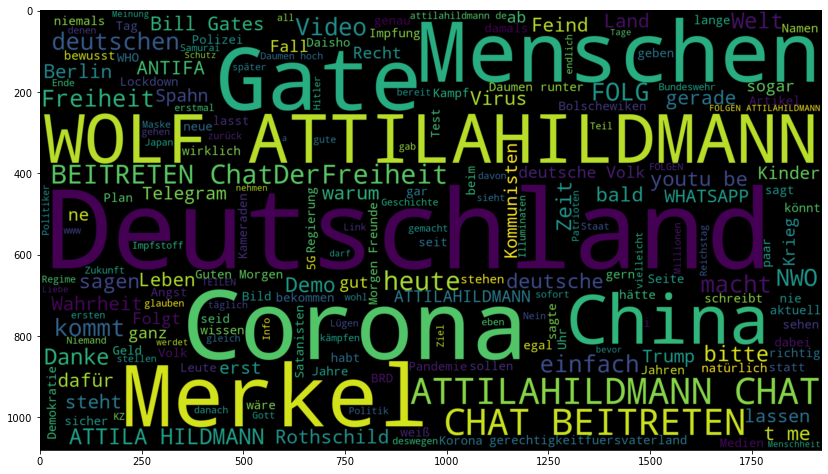

[Finished]
10.004s


In [45]:
# ATTILA HILDMANN OFFICIAL (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-25-hildmann",
    "pc-hildmann",
    ["ATTILAHILDMANN CHAT"]
)

In [ ]:
# Gerechtigkeit für das Vaterland (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-26-gerechtigkeitVaterland",
    "pc-GerechtigkeitfuerdasVaterland",
    ["gerechtigkeitfuersvaterland"]
)

In [ ]:
# Corona Virus Informationen (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-26-cvirusinfo",
    "pc-cVirusInfo",
    [])

In [ ]:
# Liberté (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-26-liberte",
    "pc-liberte",
    []
)

In [ ]:
# TODO LIST

In [ ]:
# Eva Herman Offiziell (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-27-evaherman",
    "pc-evaHerman",
    []
)

In [ ]:
# Xavier Naidoo (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-25-xavier",
    "pc-xavier",
    ["xavier_naidoo", "Xavier_Naidoo", "politische_bildersprueche", "einmal_hin_alles_drin"]
)

In [ ]:
# TODO LIST

### Public supergroups

In [ ]:
# FREIHEITS-CHAT (public_supergroup)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-28-freiheitsChat",
    "ps-freiheitsChat",
    []
)

In [ ]:
# Die deutsche Lösung - Gruppe (public_supergroup)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-30-deutscheLsg",
    "ps-DieDeutscheLoseungGruppe",
    []
)

In [ ]:
# Deutsche Patrioten (public_supergroup)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-10-01-deutschePatri",
    "ps-deutschePatrioten",
    []
)

In [ ]:
# FREIHEITSCHAT - BLITZ (public_supergroup)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-10-01-freiheitsChatBlitz",
    "ps-freiheitsChatBlitz",
    []
)

In [ ]:
# DieWahrheitundnurdieWahrheit (public_supergroup)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-10-02-chatDieWahrheit",
    "ps-DieWahrheitundnurdieWahrheit",
    []
)

In [ ]:
# TODO LIST

[Start transform text to global text string]
[Start generate wordCloud]
Top 20 occ:
Deutschland                  1.000000
Corona                       0.751402
Gate                         0.600935
Merkel                       0.593458
Menschen                     0.576636
WOLF ATTILAHILDMANN          0.486916
China                        0.484112
ATTILAHILDMANN CHAT          0.457009
CHAT BEITRETEN               0.453271
BEITRETEN ChatDerFreiheit    0.449533
heute                        0.426168
FOLG                         0.390654
Video                        0.373832
deutschen                    0.363551
einfach                      0.362617
macht                        0.357944
Freiheit                     0.357944
kommt                        0.353271
NWO                          0.341121
Welt                         0.302804
dtype: float64
[Start generate figure]


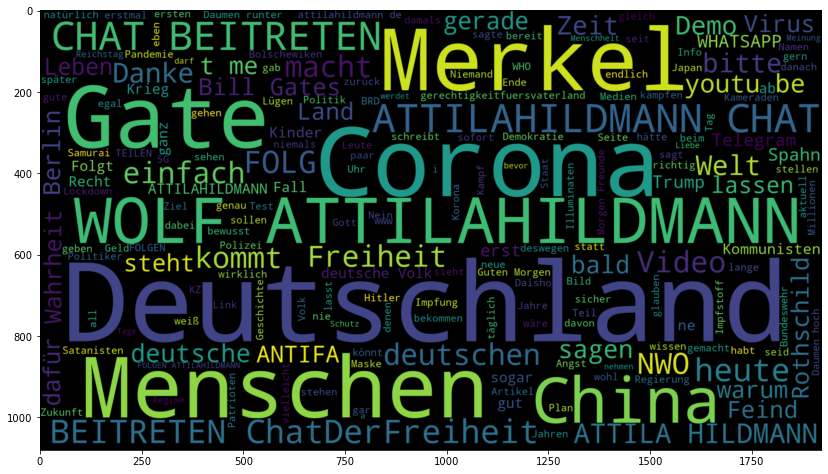

[Finished]
9.961s


In [46]:
plotChannelWordCloud(
    "global",
    "global",
    []
)

## Concordance

In [ ]:
#t = nltk.text.Text("Hallo Welt. Was machst du gerade? Das ist nur ein Test! Schöne Welt! Das geht ja gar nicht Welt!")